In [319]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gamma

In [342]:
df = pd.read_csv("wine_data.csv",index_col=[0]).dropna(subset=['price'])
# df.head(100)

In [345]:
Q99 = int(df["price"].quantile(0.99))
# print(Q99)
Q10 = int(df["price"].quantile(0.10))
Q10

12

In [346]:
df.drop(df[ (df['price'] > Q99)].index , inplace=True)
# df.head(100)

Create a new column with price intervals
Count the points in each interval for each point value
Rename the columns to match your desired format
Normalize each column to add up to 100
Fill NaN values with 0

In [347]:
df['price_interval'] = pd.cut(df['price'], bins=np.arange(0, Q99+5, 5), right=False)

temp = pd.crosstab(index=df['points'], columns=df['price_interval'])
temp.columns = ["under"+str(int(b)) for b in range(5,Q99+5,5)]

df = temp.apply(lambda x: (x / x.sum()) * 100, axis=0)
df = df.fillna(0).astype(int)

print(df)

        under5  under10  under15  under20  under25  under30  under35  under40  \
points                                                                          
80           0        2        1        0        0        0        0        0   
81           0        4        2        1        1        0        0        0   
82           0        8        5        3        2        2        2        1   
83          11       14        9        5        3        2        2        2   
84          50       21       14        8        7        5        4        3   
85           5       18       16       11        8        7        5        5   
86          33       14       17       14       11       10        8        7   
87           0        9       16       20       17       14       13       12   
88           0        4        9       14       16       15       13       11   
89           0        1        4        7       10       11       11       10   
90           0        0     

In [348]:
df_weight = df.multiply((df.index - 80), axis=0)
print(df_weight)

        under5  under10  under15  under20  under25  under30  under35  under40  \
points                                                                          
80           0        0        0        0        0        0        0        0   
81           0        4        2        1        1        0        0        0   
82           0       16       10        6        4        4        4        2   
83          33       42       27       15        9        6        6        6   
84         200       84       56       32       28       20       16       12   
85          25       90       80       55       40       35       25       25   
86         198       84      102       84       66       60       48       42   
87           0       63      112      140      119       98       91       84   
88           0       32       72      112      128      120      104       88   
89           0        9       36       63       90       99       99       90   
90           0        0     

In [349]:
mean = df_weight.sum()/100
mean

under5       4.56
under10      4.24
under15      5.17
under20      6.12
under25      6.74
under30      7.22
under35      7.65
under40      8.21
under45      8.70
under50      9.07
under55      9.25
under60      9.72
under65      9.75
under70      9.99
under75     10.52
under80      9.90
under85     10.45
under90     10.83
under95     10.93
under100    11.09
under105    11.00
under110    11.52
under115    10.96
under120    11.39
under125    11.84
under130    11.46
under135    11.92
under140    11.05
under145    11.67
under150    11.90
dtype: float64

In [350]:
# transposed_df = mean.transpose()

# Set the new column names and reset the index
# transposed_df.columns = df.index
# transposed_df.index.name = 'ID'

# Print the transposed DataFrame
# print(transposed_df)

In [351]:
# List of means from the other DataFrame
means = mean.values.flatten().tolist()

# Create an empty dictionary to store the results
results = {}

# Iterate over each column in the original DataFrame
for column in df.columns:
    squared_diff = (((df[column[0]] - means) ** 2) * df[column]).sum()
    results[column] = squared_diff

# # Print the results in the specified format
# for column, value in results.items():
#     print(f"{column}    {value}")


KeyError: 'u'

In [352]:
# List of means from the other DataFrame
means = mean.values.flatten().tolist()

# Initialize an empty DataFrame to store the results
result_df = pd.DataFrame(columns=df.columns)

# Iterate over each row in the original DataFrame
for index, row in df.iterrows():
    squared_diffs = ((row - means) ** 2) * row
    result_df = pd.concat([result_df, squared_diffs.to_frame().T])
# Set the row index of the result DataFrame to match the original DataFrame
result_df.index = df.index

# Print the result
print(result_df)


             under5    under10    under15    under20    under25   under30  \
points                                                                      
80           0.0000    10.0352    17.3889     0.0000     0.0000    0.0000   
81           0.0000     0.2304    20.0978    26.2144    32.9476    0.0000   
82           0.0000   113.1008     0.1445    29.2032    44.9352   54.4968   
83         456.2096  1333.6064   132.0201     6.2720    41.9628   54.4968   
84      103239.6800  5898.8496  1091.5646    28.2752     0.4732   24.6420   
85           0.9680  3408.0768  1876.6224   261.9584    12.7008    0.3388   
86       26691.5088  1333.6064  2379.1313   869.3216   199.6236   77.2840   
87           0.0000   203.9184  1876.6224  3853.0880  1789.5492  643.5576   
88           0.0000     0.2304   132.0201   869.3216  1371.9616  907.9260   
89           0.0000    10.4976     5.4756     5.4208   106.2760  157.1724   
90           0.0000     0.0000    20.0978     5.4208   199.6236  434.3092   

In [353]:
variance = df.var()
variance

# # Calculate the squared differences
# squared_diffs = ((df - mean) ** 2).multiply(df,axis=1)
# # Calculate the variance (average of squared differences)
# variance = squared_diffs.mean()
# variance
# df_mean = pd.DataFrame(mean)
# print(df_mean)
# for index, row in df.iterrows():
#     squared_diffs = ((row - means) ** 2) * row
#     result_df = result_df.append(squared_diffs, ignore_index=True)

under5      163.414286
under10      45.461905
under15      38.961905
under20      35.157143
under25      31.557143
under30      28.247619
under35      26.647619
under40      24.857143
under45      25.657143
under50      29.257143
under55      27.947619
under60      30.561905
under65      28.947619
under70      30.657143
under75      34.947619
under80      27.433333
under85      30.733333
under90      30.547619
under95      36.347619
under100     32.633333
under105     29.033333
under110     44.761905
under115     32.957143
under120     37.461905
under125     36.557143
under130     31.357143
under135     34.057143
under140     27.957143
under145     47.547619
under150     52.257143
dtype: float64

In [354]:
alpha_mom = (mean**2)/variance
beta_mom = variance/mean
alpha_mom, beta_mom

(under5      0.127245
 under10     0.395443
 under15     0.686027
 under20     1.065343
 under25     1.439535
 under30     1.845409
 under35     2.196162
 under40     2.711659
 under45     2.950056
 under50     2.811789
 under55     3.061531
 under60     3.091378
 under65     3.283949
 under70     3.255362
 under75     3.166751
 under80     3.572661
 under85     3.553227
 under90     3.839543
 under95     3.286732
 under100    3.768788
 under105    4.167623
 under110    2.964807
 under115    3.644782
 under120    3.463041
 under125    3.834698
 under130    4.188251
 under135    4.172000
 under140    4.367489
 under145    2.864263
 under150    2.709869
 dtype: float64,
 under5      35.836466
 under10     10.722147
 under15      7.536152
 under20      5.744631
 under25      4.682069
 under30      3.912413
 under35      3.483349
 under40      3.027667
 under45      2.949097
 under50      3.225705
 under55      3.021364
 under60      3.144229
 under65      2.968987
 under70      3.068783
 

In [355]:
df_result.uder5.hist(density=True, bins=10)
plt.plot(np.linspace(0, 10), gamma.pdf(np.linspace(0, 10), alpha_mom[0], beta_mom[0]))
# plt.xlim([0, 50])

AttributeError: 'DataFrame' object has no attribute 'uder5'

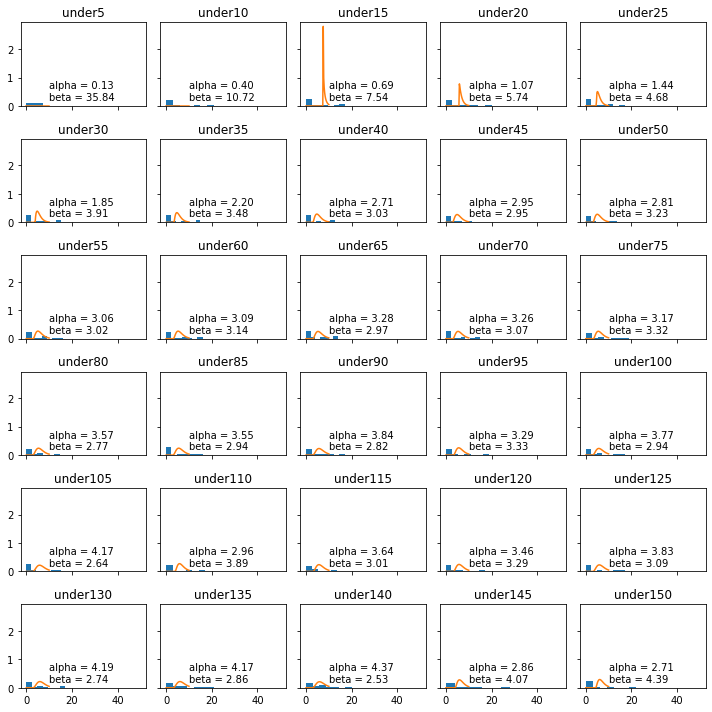

In [356]:
# List of values for "underX"
underX_values = [i for i in range(5,Q99+5,5)]  # Fill in the desired values

# Create a figure with subplots
fig, axs = plt.subplots(6, 5, figsize=(10, 10), sharex=True, sharey=True)


for i, underX in enumerate(underX_values):
    
    row_idx = i // 5
    col_idx = i % 5

    # Create a histogram for the current "underX"
    axs[row_idx, col_idx].hist(result[f'under{underX}'], density=True, bins=7)
    
    # Fit and plot the gamma distribution for the current "underX"
    x = np.linspace(0, 10)
    axs[row_idx, col_idx].plot(x, gamma.pdf(x, alpha_mom[i], beta_mom[i]))
#     axs[row_idx, col_idx].plot(xlim(0,15))

    # Annotate with parameter estimates
    label = 'alpha = {0:.2f}\nbeta = {1:.2f}'.format(alpha_mom[i], beta_mom[i])
    axs[row_idx, col_idx].annotate(label, xy=(10, 0.2))

# Set titles for the subplots (underX values)
# for i, underX in enumerate(underX_values):
    axs[row_idx, col_idx].set_title(f'under{underX}')

plt.tight_layout()
plt.show()
